#Final Code

In [1]:
# Install Hugging Face Transformers and Datasets libraries
!pip install transformers datasets
!pip install nltk wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Import necessary libraries
import os
import pandas as pd
import nltk
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score


In [3]:
# Download NLTK punkt tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from nltk.tokenize import PunktSentenceTokenizer

# Training text
training_text = "Dr. Smith is a renowned scientist. She lives in the U.S.A. Her research is groundbreaking!"

# Initialize and train Punkt
tokenizer = PunktSentenceTokenizer()

# Tokenize a new text
new_text = "Keerthana is always late. Hope this will be done! We need to finish this asap."
sentences = tokenizer.tokenize(new_text)

print(sentences)

['Keerthana is always late.', 'Hope this will be done!', 'We need to finish this asap.']


In [5]:
#mount drive for the dataset
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


In [6]:
# Define directories for judgment and summary text files
summary_dir = "/content/Drive/MyDrive/dataset/IN-Ext/summary/full/A1"
judgment_dir = "/content/Drive/MyDrive/dataset/IN-Ext/judgement"

In [7]:
# Initialize lists to store text data
judgments = []
summaries = []

In [8]:
# Function to read all text files in a directory
def read_files(directory):
    texts = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                texts[filename] = file.read()
    return texts

In [9]:
# Load text files into dictionaries
judgment_texts = read_files(judgment_dir)
summary_texts = read_files(summary_dir)

In [10]:
# Pair judgments and summaries by filename
for filename, judgment_text in judgment_texts.items():
    summary_text = summary_texts.get(filename, None)
    if summary_text:  # Only keep pairs where both files exist
        judgments.append(judgment_text)
        summaries.append(summary_text)

In [11]:
# Create DataFrame
df = pd.DataFrame({'judgment': judgments, 'summary': summaries})
print("DataFrame created with paired judgments and summaries.")
df.head()

DataFrame created with paired judgments and summaries.


,judgment,summary
0,an fir was registered on 23 3 1996 on the stat...,FACTS\nan fir was registered on 23.3.1996 on t...
1,the appellant is a trust which wanted to estab...,FACTS\nthe appellant is a trust which wanted t...
2,aggrieved by the decision of customs excise an...,FACTS\nappellants were engaged in the manufact...
3,for the sake of convenience we refer to the fa...,"FACTS\nspan diagnostics limited,respondent no...."
4,this civil appeal by special leave is directed...,FACTS\nthe civil appeal by special leave is di...


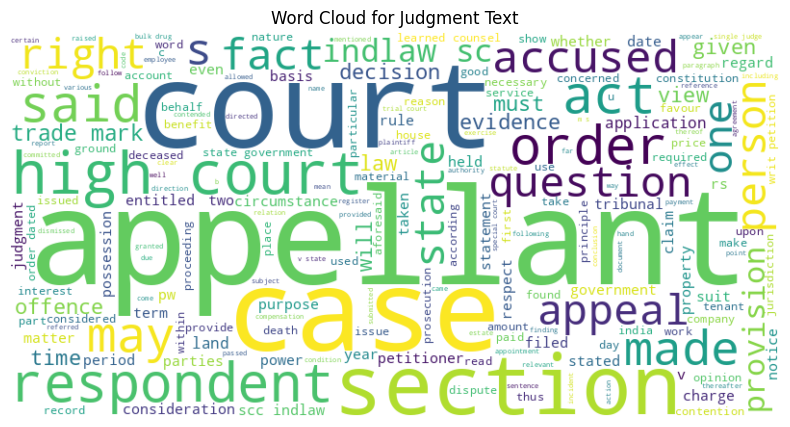

In [12]:
# Word Cloud for Judgment Text
judgment_text = " ".join(df['judgment'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(judgment_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Judgment Text")
plt.show()

In [13]:
# Label sentences from judgment based on presence in summary
def label_sentences(judgment, summary):
    judgment_sentences = nltk.sent_tokenize(judgment)
    summary_sentences = set(nltk.sent_tokenize(summary))  # Exact matches for labeling

    labeled_data = []
    for sentence in judgment_sentences:
        label = 1 if sentence in summary_sentences else 0
        labeled_data.append({'sentence': sentence, 'label': label})
    return labeled_data

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
# Apply labeling to entire dataset
labeled_sentences = []
for _, row in df.iterrows():
    labeled_sentences.extend(label_sentences(row['judgment'], row['summary']))

In [16]:
# Convert labeled data into DataFrame
labeled_df = pd.DataFrame(labeled_sentences)
print("Labeled Data Sample:", labeled_df.head())

Labeled Data Sample:                                             sentence  label
0  an fir was registered on 23 3 1996 on the stat...      0
1  she stated that on the night of 2223 3 1996while.      0
2  she and her daughter in law sheela devi were s...      0
3  that around 00 30 am the appellant again came ...      0
4  the police investigated into the said complain...      0


In [17]:
# Split labeled data into train and test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42)

In [18]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=512)

In [20]:
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

In [21]:
# Convert dataset to pandas for manipulation
train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)

train_df = train_dataset.to_pandas()

# Reset index to avoid issues during concatenation later
# Drop the existing index to prevent conflicts
train_df = train_df.reset_index(drop=True)

# ***Determine the label value representing the majority class***
# ***Replace 'your_majority_label' with the actual label value from your dataset***
# For example, if the majority label is 'positive', use:
majority_label = labeled_df['label'].mode()[0]  # Get the most frequent label
minority_label = labeled_df['label'].value_counts().index[-1] # Get the least frequent label


# Separate majority and minority classes
majority = train_df[train_df['label'] == majority_label]
minority = train_df[train_df['label'] == minority_label]

from sklearn.utils import resample
# Oversample minority class
minority_oversampled = resample(minority,
                                 replace=True,
                                 n_samples=len(majority), # Match majority class size
                                 random_state=42)

# Combine oversampled minority with majority class
balanced_train_df = pd.concat([majority, minority_oversampled])

# Reset index before creating the Dataset and drop the old index
balanced_train_df = balanced_train_df.reset_index(drop=True)

# Convert back to Hugging Face Dataset
train_dataset = Dataset.from_pandas(balanced_train_df)

Map:   0%|          | 0/6427 [00:00<?, ? examples/s]

In [22]:
# Set PyTorch format
train_dataset = train_dataset.map(tokenize, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/12244 [00:00<?, ? examples/s]

In [23]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
    num_labels=2,
    classifier_dropout=0.3  # Increase dropout rate
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure 'label' column is of numeric type, handling batched input
train_dataset = train_dataset.map(lambda examples: {'label': [int(l) for l in examples['label']]}, batched=True)

# Get unique class labels, ensuring they are integers
# FIX: Use np.unique to get unique values from the 'label' column
# FIX: Flatten the labels before applying np.unique to handle batched data
# Get all labels as a list

# Modified to handle 0-d tensors
all_labels = []
for label in train_dataset['label']:
    if isinstance(label, torch.Tensor) and label.dim() == 0:
        all_labels.append(label.item())
    else:
        all_labels.extend(label)

unique_classes = np.unique(all_labels) # Find unique labels

# Compute class weights for imbalanced data
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=unique_classes,
                                    y=all_labels)  # FIX: Pass flattened labels
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Custom metrics function (unchanged)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "recall_1": recall_score(labels, predictions, pos_label=1),
        "weighted_f1": f1_score(labels, predictions, average="weighted")
    }

Map:   0%|          | 0/12244 [00:00<?, ? examples/s]

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,  # Reduce learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,  # Regularization
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
#!pip install transformers datasets
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, default_data_collator
from transformers import BertForSequenceClassification

# Define a custom training step function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):  # Add num_items_in_batch argument
        """
        Override the compute_loss function to incorporate class weights.
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # Assuming your model outputs a dictionary with 'logits'
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    data_collator=default_data_collator,
)

In [27]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Recall 1,Weighted F1
1,0.249100,0.654455,0.781581,0.640000,0.842421


TrainOutput(global_step=1531, training_loss=0.3486013948177684, metrics={'train_runtime': 665.8542, 'train_samples_per_second': 18.388, 'train_steps_per_second': 2.299, 'total_flos': 3221531761827840.0, 'train_loss': 0.3486013948177684, 'epoch': 1.0})

In [28]:

# Function to generate extractive summaries
def extractive_summary(judgment_text):
    sentences = nltk.sent_tokenize(judgment_text)
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to the same device as the model
    for key in inputs:
        inputs[key] = inputs[key].to(model.device)

    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

    # Select sentences labeled as part of the summary (label 1)
    summary = ' '.join([sent for sent, pred in zip(sentences, predictions) if pred == 1])
    return summary

# Apply model on test data for evaluation
test_df['predicted_summary'] = test_df['sentence'].apply(extractive_summary)
print("Sample Extractive Summary Results:", test_df[['sentence', 'predicted_summary']].head())

Sample Extractive Summary Results:                                                sentence  \
6891  reasonableness for purposes of judging whether...   
4119  according to the appellant the aforesaid issue...   
3032  it may therefore be understood that the plenar...   
3795  verified that the above statements are true to...   
318   accordingly the commissioner a dismissed the a...   

                                      predicted_summary  
6891  reasonableness for purposes of judging whether...  
4119  according to the appellant the aforesaid issue...  
3032                                                     
3795                                                     
318                                                      


In [29]:
# Generate classification report
y_true = test_df['label'].tolist()
y_pred = [1 if s in test_df['predicted_summary'].tolist() else 0 for s in test_df['sentence'].tolist()]
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.87      1532
           1       0.13      0.64      0.21        75

    accuracy                           0.78      1607
   macro avg       0.55      0.71      0.54      1607
weighted avg       0.94      0.78      0.84      1607



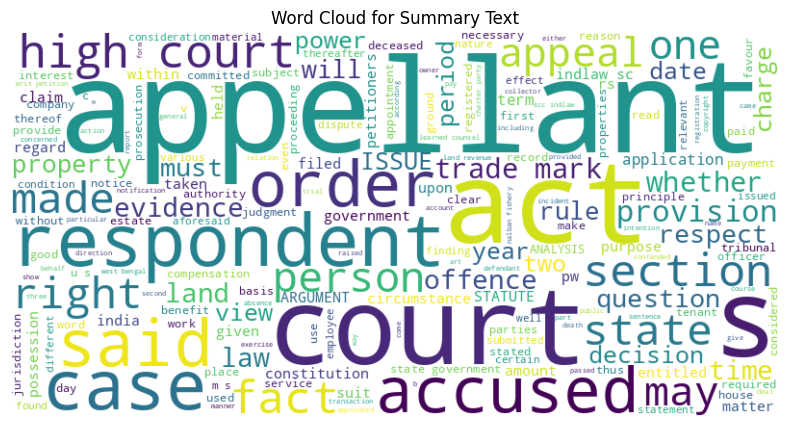

In [30]:
# Word Cloud for Summary Text
summary_text = " ".join(df['summary'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(summary_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Summary Text")
plt.show()

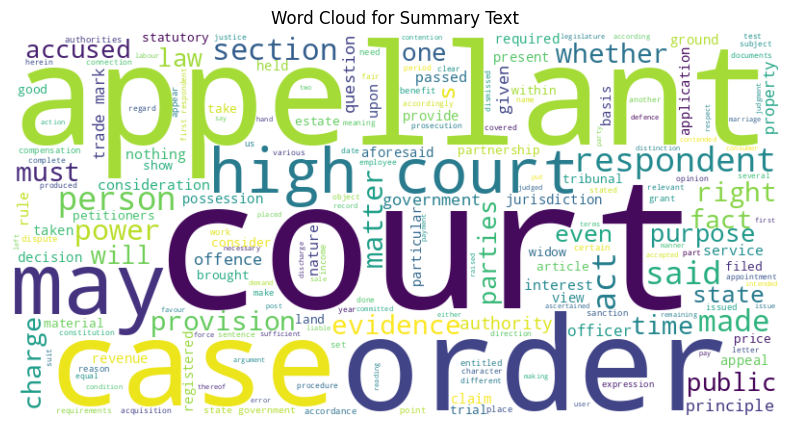

In [31]:

# Word Cloud for predicted Summary Text
summary_text = " ".join(test_df['predicted_summary'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(summary_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Summary Text")
plt.show()

In [32]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [33]:
import gradio as gr

In [34]:
# Function to generate extractive summaries and set up Gradio interface
def extractive_summary_gradio(text):
    # Split the judgment text into sentences
    sentences = nltk.sent_tokenize(text)

    # Tokenize the sentences and prepare them for BERTSUM model
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)

    # Move inputs to the same device as the model (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)  # Get predictions (1 or 0 for each sentence)

    # Select sentences labeled as part of the summary (label 1)
    summary = ' '.join([sent for sent, pred in zip(sentences, predictions) if pred == 1])
    return summary

# Set up Gradio Interface
gr_interface = gr.Interface(fn=extractive_summary_gradio,
                            inputs=gr.Textbox(lines=15, placeholder="Enter text to summarize..."),
                            outputs=gr.Textbox(label="Extractive Summary"))

# Launch the Gradio interface
gr_interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5491be00f133f4a141.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
